In [41]:
%matplotlib inline
import matplotlib.pyplot as plt
import tables
import pandas as pd
import numpy as np
from toolz import memoize
from toise import plotting, surfaces, util, effective_areas, angular_resolution
import matplotlib as mpl
import photospline
from scipy import optimize
'''from autograd.misc.flatten import flatten_func
import autograd
import autograd.numpy as n'''
import os
import histlite 
import nuflux
import tables
import histlite as hl
#import warnings
#warnings.filterwarnings("ignore") # turn off warnings

In [42]:
import astropy
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import EarthLocation, AltAz

In [43]:
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['figure.facecolor'] = mpl.rcParams['savefig.facecolor'] = 'w'
mpl.rcParams['legend.framealpha'] = 1
mpl.rc('font', size=15)

In [44]:
#base_dir = '/home/steve/pone/data/'
base_dir = '/home/ssclafani/data/'

In [45]:
f = tables.open_file(base_dir + 'LI_ranged_high_stats.hdf5')

In [46]:
len(f.root.I3EventHeader.cols.Event[:])

77782

In [47]:
#len(f.root.I3EventHeader.cols.Event[:]) / 352.

In [48]:
'''fig, axs = plt.subplots(2,2, figsize=(9,9))
f = tables.open_file(base_dir + '3_no_reco.hdf5')
ax = axs[0][0]
ax.hist(f.root.I3EventHeader.cols.Event[:]);
ax.set_title('3 String with NO RECO')
ax.set_xlabel('Event Number in File')

f = tables.open_file(base_dir + '70_no_reco.hdf5')
ax = axs[0][1]
ax.hist(f.root.I3EventHeader.cols.Event[:]);
ax.set_title('3 String with NO RECO')
ax.set_xlabel('Event Number in File')

f = tables.open_file(base_dir + '3_reco.hdf5')
ax = axs[1][0]
ax.hist(f.root.I3EventHeader.cols.Event[:]);
ax.set_title('3 String with RECO')
ax.set_xlabel('Event Number in File')

f = tables.open_file(base_dir + '70_reco.hdf5')
ax = axs[1][1]
ax.hist(f.root.I3EventHeader.cols.Event[:]);
ax.set_title('70 String with RECO')
ax.set_xlabel('Event Number in File')

plt.tight_layout()'''

"fig, axs = plt.subplots(2,2, figsize=(9,9))\nf = tables.open_file(base_dir + '3_no_reco.hdf5')\nax = axs[0][0]\nax.hist(f.root.I3EventHeader.cols.Event[:]);\nax.set_title('3 String with NO RECO')\nax.set_xlabel('Event Number in File')\n\nf = tables.open_file(base_dir + '70_no_reco.hdf5')\nax = axs[0][1]\nax.hist(f.root.I3EventHeader.cols.Event[:]);\nax.set_title('3 String with NO RECO')\nax.set_xlabel('Event Number in File')\n\nf = tables.open_file(base_dir + '3_reco.hdf5')\nax = axs[1][0]\nax.hist(f.root.I3EventHeader.cols.Event[:]);\nax.set_title('3 String with RECO')\nax.set_xlabel('Event Number in File')\n\nf = tables.open_file(base_dir + '70_reco.hdf5')\nax = axs[1][1]\nax.hist(f.root.I3EventHeader.cols.Event[:]);\nax.set_title('70 String with RECO')\nax.set_xlabel('Event Number in File')\n\nplt.tight_layout()"

In [49]:
#f.root.I3MCWeightDict.cols.OneWeight

In [50]:
'''def rotate_event(azimuth, zenith):
    PONE = {
        "lon": -123.3656 * u.deg,
        "lat":48.4284 * u.deg} #48.4284 * u.deg}
    loc = EarthLocation(lon= PONE['lon'], lat= PONE['lat'])
    times = np.random.uniform(size=len(azimuth), low=53005, high=53371)
    t = Time(times, format='mjd')
    coords = astropy.coordinates.AltAz(az=azimuth*u.rad, alt=(np.pi/2 - zenith)*u.rad, 
                                   obstime = t, location=loc)
    

    eq = astropy.coordinates.SkyCoord(coords)
    ra = eq.icrs.ra.rad
    dec = eq.icrs.dec.rad
    return ra, dec
'''

'def rotate_event(azimuth, zenith):\n    PONE = {\n        "lon": -123.3656 * u.deg,\n        "lat":48.4284 * u.deg} #48.4284 * u.deg}\n    loc = EarthLocation(lon= PONE[\'lon\'], lat= PONE[\'lat\'])\n    times = np.random.uniform(size=len(azimuth), low=53005, high=53371)\n    t = Time(times, format=\'mjd\')\n    coords = astropy.coordinates.AltAz(az=azimuth*u.rad, alt=(np.pi/2 - zenith)*u.rad, \n                                   obstime = t, location=loc)\n    \n\n    eq = astropy.coordinates.SkyCoord(coords)\n    ra = eq.icrs.ra.rad\n    dec = eq.icrs.dec.rad\n    return ra, dec\n'

In [51]:
def make_array_nugen(string, reco=False, nfiles=1000, nevents=100):

    f = tables.open_file(base_dir + 'Nugen_{}_daq.hdf5'.format(string))
    
    
    event = f.root.I3EventHeader.cols.Event[:]
    true_zenith = f.root.NuGPrimary.cols.zenith[:]
    true_azimuth = f.root.NuGPrimary.cols.azimuth[:]
    true_energy = f.root.NuGPrimary.cols.energy[:]
    oneweight = f.root.I3MCWeightDict.cols.OneWeight[:]
    ow = oneweight / (nfiles * nevents)
    #true_ra, true_dec = rotate_event(true_azimuth, true_zenith)  
    w_astro = 1e-18 *ow *(true_energy/1e5)**-2
    w_atmo = 1e-18 *ow *(true_energy/1e5)**-3.7
    flux = nuflux.makeFlux('H3a_SIBYLL23C')
    nu_type=nuflux.NuMu
    nu_energy=true_energy # in GeV
    nu_cos_zenith = np.cos(true_zenith)
    w_h3a =2*ow* flux.getFlux(nu_type,nu_energy,nu_cos_zenith)

  
    array = np.vstack([event, true_zenith, true_azimuth, true_energy, ow, w_astro, w_atmo, w_h3a])
    df = pd.DataFrame(array.T, 
                      columns=['event' , 'true_zenith', 'true_azimuth',  'true_energy',  'ow', 
                               'w_astro','w_atmo', 'w_h3a'])
    return df

In [52]:
f = tables.open_file(base_dir + 'leptonweight_70.hdf5')

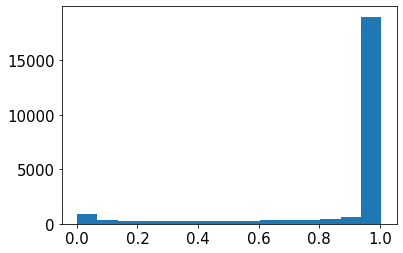

In [53]:
plt.hist(f.root.LeptonInjection_SurvivalProb.cols.value[:], bins=15);

In [54]:
np.unique(f.root.EventProperties.cols.initialType[:])

array([-14,  14], dtype=int32)

In [55]:
def make_array_leptonweight(string, reco=False, nfiles=1000, nevents=100):

    f = tables.open_file(base_dir + 'LI_ranged_high_stats.hdf5'.format(string))
    
    
    event = f.root.I3EventHeader.cols.Event[:]
    true_zenith = f.root.EventProperties.cols.zenith[:]
    true_azimuth = f.root.EventProperties.cols.azimuth[:]
    true_energy = f.root.EventProperties.cols.totalEnergy[:]
    oneweight = f.root.LeptonInjection_oneweight.cols.value[:]
    surv_prob = f.root.LeptonInjection_SurvivalProb.cols.value[:]
    ow = oneweight  * surv_prob / nfiles # * nevents)
    #ow = (oneweight) / (nfiles)# * nevents)
    #true_ra, true_dec = rotate_event(true_azimuth, true_zenith)  
    w_astro = 1e-18 *ow *(true_energy/1e5)**-2
    w_atmo = 1e-18 *ow *(true_energy/1e5)**-3.7
    flux = nuflux.makeFlux('H3a_SIBYLL23C')
    nu_type=nuflux.NuMu
    nu_energy=true_energy # in GeV
    nu_cos_zenith = np.cos(true_zenith)
    w_h3a =2*ow* flux.getFlux(nu_type,nu_energy,nu_cos_zenith)

  
    array = np.vstack([event, true_zenith, true_azimuth,true_energy, ow,
                       w_astro, w_atmo, w_h3a])
    df = pd.DataFrame(array.T, 
                      columns=['event' , 'true_zenith', 'true_azimuth','true_energy',  'ow', 
                               'w_astro','w_atmo', 'w_h3a'])
    return df

In [56]:
mc = {}
nugen = {}
strings = [70]
for i, string in enumerate(strings):
    mc[string] = make_array_leptonweight(string, reco=False, nfiles=1000, nevents=100)
    nugen[string] = make_array_nugen(string, reco=False, nfiles=1000, nevents=100)

In [57]:
sum(nugen[70].ow)

310898356050686.9

In [58]:
#rates
for string in [70]:
    print('Lepton Injector')
    print('{} String : {:.2} Hz, Astro Events / year: {:.3}'.format(string, sum(mc[string].w_astro), 
                                                                     sum(mc[string].w_astro) * 1 * 365 * 86400))
    print('{} String : {:.2} Hz, Atmo Events (E^-3.7)/ year: {:.3}'.format(string, sum(mc[string].w_atmo), sum(mc[string].w_atmo) * 1 * 365 * 86400))
    print('{} String : {:.2} Hz, Atmo Events H3a / year: {:.3}'.format(string, sum(mc[string].w_h3a), 
                                                                        sum(mc[string].w_h3a) * 1 * 365 * 86400))

    print(' ')

Lepton Injector
70 String : 8.9e-06 Hz, Astro Events / year: 2.81e+02
70 String : 0.0012 Hz, Atmo Events (E^-3.7)/ year: 3.78e+04
70 String : 0.0035 Hz, Atmo Events H3a / year: 1.11e+05
 


In [59]:
#rates
for string in [70]:
    print('Nugen')
    print('{} String : {:.2} Hz, Astro Events / year: {:.3}'.format(string, sum(nugen[string].w_astro), 
                                                                     sum(nugen[string].w_astro) * 1 * 365 * 86400))
    print('{} String : {:.2} Hz, Atmo Events (E^-3.7)/ year: {:.3}'.format(string, sum(nugen[string].w_atmo), sum(nugen[string].w_atmo) * 1 * 365 * 86400))
    print('{} String : {:.2} Hz, Atmo Events H3a / year: {:.3}'.format(string, sum(nugen[string].w_h3a), 
                                                                        sum(nugen[string].w_h3a) * 1 * 365 * 86400))

    print(' ')

Nugen
70 String : 1.6e-06 Hz, Astro Events / year: 51.1
70 String : 0.00085 Hz, Atmo Events (E^-3.7)/ year: 2.67e+04
70 String : 0.0011 Hz, Atmo Events H3a / year: 3.33e+04
 


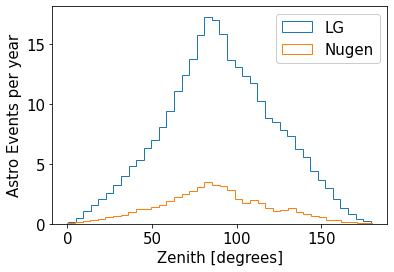

In [60]:
lt = 86400 * 365
plt.hist(np.degrees(mc[70].true_zenith), bins=40, weights=mc[70].w_astro * lt, histtype='step' , label = 'LG');
plt.hist(np.degrees(nugen[70].true_zenith), bins=40, weights=nugen[70].w_astro * lt, histtype='step', label = 'Nugen');
plt.xlabel('Zenith [degrees]')
plt.ylabel('Astro Events per year')
plt.legend()

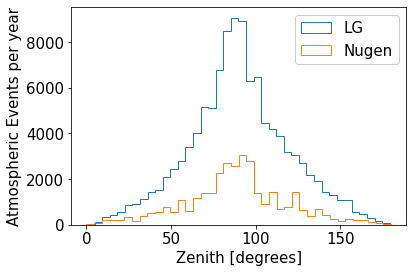

In [61]:
lt = 86400 * 365
plt.hist(np.degrees(mc[70].true_zenith), bins=40, weights=mc[70].w_h3a * lt, histtype='step' , label = 'LG');
plt.hist(np.degrees(nugen[70].true_zenith), bins=40, weights=nugen[70].w_h3a * lt, histtype='step', label = 'Nugen');
plt.xlabel('Zenith [degrees]')
plt.ylabel('Atmospheric Events per year')
plt.legend()

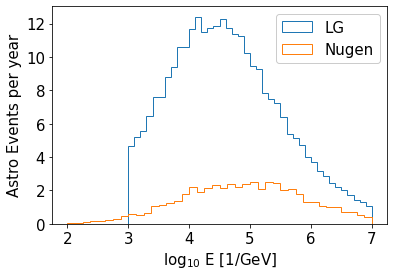

In [62]:
plt.hist(np.log10(mc[70].true_energy), bins=40, weights=mc[70].w_astro * lt, histtype='step', label = 'LG');
plt.hist(np.log10(nugen[70].true_energy), bins=40, weights=nugen[70].w_astro * lt, histtype='step', label = 'Nugen');
plt.xlabel('log$_{10}$ E [1/GeV]')
plt.ylabel('Astro Events per year')
plt.legend()

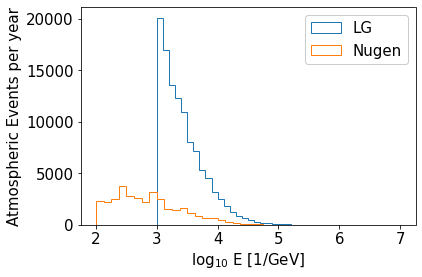

In [63]:
plt.hist(np.log10(mc[70].true_energy), bins=40, weights=mc[70].w_h3a * lt, histtype='step', label = 'LG');
plt.hist(np.log10(nugen[70].true_energy), bins=40, weights=nugen[70].w_h3a * lt, histtype='step', label = 'Nugen');
plt.xlabel('log$_{10}$ E [1/GeV]')
plt.ylabel('Atmospheric Events per year')
plt.legend()

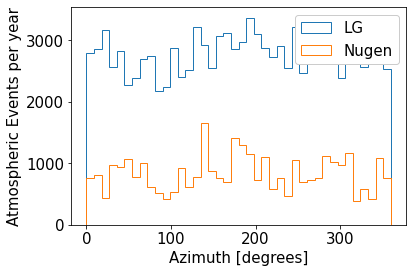

In [64]:
plt.hist(np.degrees(mc[70].true_azimuth), bins=40, weights=mc[70].w_h3a * lt, histtype='step', label = 'LG');
plt.hist(np.degrees(nugen[70].true_azimuth), bins=40, weights=nugen[70].w_h3a * lt, histtype='step', label = 'Nugen');
plt.xlabel('Azimuth [degrees]')
plt.ylabel('Atmospheric Events per year')
plt.legend()

In [65]:
sum(nugen[70].w_astro)

1.6215784089625889e-06

In [66]:
#aeffs is area_weight in units of GeV m^2 sr similar to oneweight 
# but oneweight is in terms of cm^2

In [67]:
def effa_plot_notlogged(ax, mc_dict, string=70, zen_deg_min = 0, zen_deg_max = 180, 
                        selection_eff = 1,label = 'MISC', color = 'k', ls = '-'):
    a = mc_dict[string]
    mask = (a.true_zenith < np.radians(zen_deg_max)) & (a.true_zenith > np.radians(zen_deg_min))
    
    dlogE=.2
    bins = 10**np.arange(3,7.01,dlogE)
    solid_angle=2*np.pi*(np.cos(np.radians(zen_deg_min))) - np.cos(np.radians(zen_deg_max))
    area=  (1/(1e4*np.log(10)) * (a.ow[mask] / ( (a.true_energy[mask]) *  solid_angle *  dlogE)))
    #(1/1e4*np.log(10)) *
    h = hl.hist((a.true_energy[mask]), 
                #weights=dats.effective_area[mask] / (solid_angle * dlogE), 
                weights = selection_eff *area,
                bins=bins);
    hl.plot1d(ax, h, histtype='step', linewidth=3, color=color, label=label, ls = ls,  log=True)
    ''' ax.loglog()

    ax.grid()
    #ax.legend(loc='lower right')
    ax.set_ylabel('$A_\mathsf{Eff}$($m^2$)')
    ax.set_xlabel('log$_{10}$(E) [1/GeV]')
    '''
    #ax.set_xlim((10**2,10**7))
    #ax.set_ylim((1e-4,1e3))
    #plt.tight_layout()
    return h

In [68]:
#pstracks_hist = np.load('/home/ssclafani//data/pstracks_effa_all.hist.npy', allow_pickle=True)[()]
#dnnc_hist = np.load('/home/steve/pone/data/DNNC_effa_all.hist.npy', allow_pickle=True)[()]
#pstracks_hist = np.load('/home/steve/pone/data/pstracks_effa_north.hist.npy', allow_pickle=True)[()]

In [69]:
selection_eff = .004/32

In [70]:
ctung_effa  = np.load('/home/ssclafani/data/pone_10strings_50m_effA.npy', 
                     allow_pickle=True)[()]

In [71]:
len(ctung_effa['logE'])

39

In [72]:
print(np.cos(np.radians(60)))
print(np.cos(np.radians(90)))

0.5000000000000001
6.123233995736766e-17


In [73]:
geo_area = [1.25]

In [74]:
raw_geo_area = np.load('/home/ssclafani/data/pone_scripts/data/toSteve.npz', 
                     allow_pickle=True, encoding='ASCII')

In [75]:
geo_area = {}

for key in raw_geo_area.keys():
    geo_area[key] = raw_geo_area[key]

In [76]:
np.mean(geo_area['pOneArea'])

1329637.9810772918

In [77]:
soft_colors = ['#004466', '#d06050', '#2aca80', '#dd9388', '#caca68']
friendly_colors = ['#184b68', '#cf4d30', '#62badb', '#e797b4', '#eec9b4', '#f7dede']

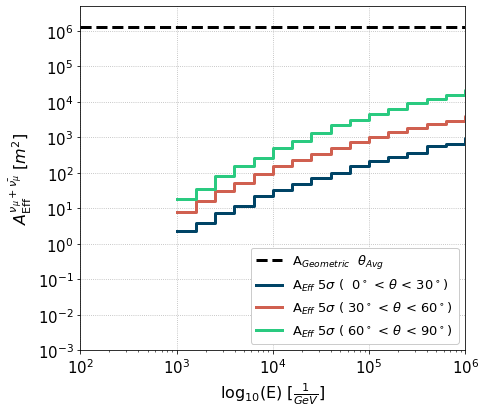

In [78]:
colors = soft_colors #['C1', 'C2', 'C3', 'C4']
strings = [70]
fig,ax = plt.subplots(figsize=(7,6))
zen_deg_mins = [0,30,60]
for i, zen_deg_min in enumerate(zen_deg_mins):
    #effa_plot_notlogged(ax, mc,  string= 70,
    #                    label=r'A$_{{Eff}}$ $\nu_\mu$ {}$^\circ$ < $\theta$ < {}$^\circ$ '.format(zen_deg_min, zen_deg_min+30), 
    #                    zen_deg_min = zen_deg_min, zen_deg_max = zen_deg_min+30, color=colors[i], ls='-', selection_eff = 1)
    effa_plot_notlogged(ax, mc,  string= 70,
                    label=r'A$_{{Eff}}$ 5$\sigma$ ( {:2.0f}$^\circ$ < $\theta$ < {}$^\circ$) '.format(zen_deg_min, zen_deg_min+30), 
                    zen_deg_min = zen_deg_min, zen_deg_max = zen_deg_min+30,  color=colors[i], ls='-', selection_eff = 25)
ax.axhline(1329637,ls='--', lw=3,
            label=r'A$_{{Geometric}}$  $\theta_{Avg}$',
            color='k')
ax.loglog()

ax.grid()
#ax.legend(loc='lower right')
ax.set_ylabel(r'$A^{\nu_\mu+\bar{\nu_\mu}}_\mathsf{Eff}$ [$m^2$]', fontsize=16)
ax.set_xlabel(r'log$_{10}$(E) [$\frac{1}{GeV}$]', fontsize=16)
ax.set_xlim(1e2,1e6)
ax.set_ylim(1e-3,5e6)
ax.set_yticks([1e-3,1e-2,1e-1,1,10, 1e2,1e3,1e4,1e5,1e6])
#ax.legend(ncol=1, bbox_to_anchor=(1.04, 1), loc="upper left")
ax.legend(ncol=1,loc="lower right", fontsize=13)
plt.tight_layout()
plt.savefig('/mnt/c/Documents and Settings/steve/Desktop/aeff_vs_geoarea_5sigma.png')

Text(0.5, 1.0, '70 string geometry comparison')

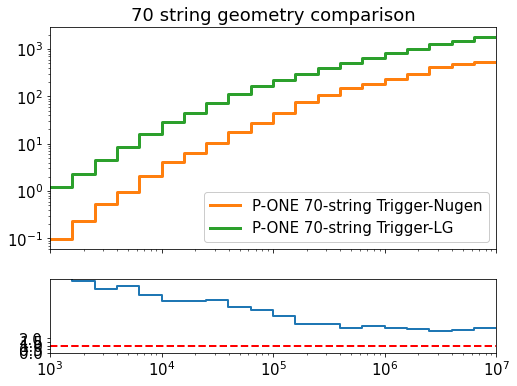

In [89]:
colors = ['C3', 'C1']
strings = [70]
fig,(ax1, ax2) = plt.subplots(2,1, sharex=True, figsize=(8,6), gridspec_kw={'height_ratios': (3,1)})

hnug = effa_plot_notlogged(ax1, nugen,  string= 70,
                           label='P-ONE 70-string Trigger-Nugen', color='C1', ls='-')
#effa_plot_notlogged(ax, mc,   string = 10, label='P-ONE 10-string Trigger-NuMu Only', color='C2', ls='-')
hlept = effa_plot_notlogged(ax1, mc,  string= 70,
                            label='P-ONE 70-string Trigger-LG', color='C2', ls='-')

hl.plot1d(ax2, hlept/hnug)
#effa_plot_notlogged(ax, mc,   string = 3, label='P-ONE 3-string Trigger', color='C3', ls='-')
#ax.step( 10**ctung_effa['logE'], ctung_effa['effA'], label='ctung')
#effa_plot_notlogged(ax, mc,selection_eff=selection_eff,  string= 70,label='P-ONE 70-string pstracksEff', color='C1', ls=':')
#effa_plot_notlogged(ax, mc, selection_eff=selection_eff,  string = 10, label='P-ONE 10-string pstracksEff', color='C2', ls=":")
#effa_plot_notlogged(ax, mc,  selection_eff=selection_eff, string = 3, label='P-ONE 3-string pstracksEff', color='C3', ls=':')

#hl.plot1d(pstracks_hist, label='PStracks Allsky', c='C5', ls='--')
#hl.plot1d(dnnc_hist, label='DNNCascade Allsky', c='C6', ls='--')
ax1.loglog()
ax1.set_xlim(1e3,1e7)
#plt.ylim(1e2,1e4)

ax2.set_ylim(0,10)
ax2.set_yticks([0,.5,1,1.5,2])
ax2.axhline(1, c='r', ls='--')
ax1.legend(ncol=1)
ax1.set_title('70 string geometry comparison')



In [80]:
#Effective Area / Geometric Area IceCube & Pone

In [81]:
#pstracks_mc = np.load('/home/steve/pone/version-004-p00/IC86_2016_MC.npy')

In [82]:
#pstracks_mc

In [83]:
'''#pstracks 2d effa
d_logE = .2
d_zen = 2 * np.pi * np.diff(np.linspace(-1,1,50))[0] 
a = pstracks_mc
bins = (np.arange(2,7.01,d_logE), np.linspace(-1,1,50))

area = (1/(1e4*np.log(10)) * (a['ow'] / (a['trueE'] * d_zen * d_logE)))
#range = [(-1,1), (3,6)]
h2d = hl.hist((np.log10(a['trueE']), np.cos(a['trueZen'])),
              weights=area,
              bins=bins)
'''

"#pstracks 2d effa\nd_logE = .2\nd_zen = 2 * np.pi * np.diff(np.linspace(-1,1,50))[0] \na = pstracks_mc\nbins = (np.arange(2,7.01,d_logE), np.linspace(-1,1,50))\n\narea = (1/(1e4*np.log(10)) * (a['ow'] / (a['trueE'] * d_zen * d_logE)))\n#range = [(-1,1), (3,6)]\nh2d = hl.hist((np.log10(a['trueE']), np.cos(a['trueZen'])),\n              weights=area,\n              bins=bins)\n"

In [84]:
'''fig, ax = plt.subplots()
hl.plot2d(ax, h2d, cbar=True, clabel='A$_{eff}$(m$^2$)', log=True, vmin=1e-5, vmax=1e3)
ax.set_yticks(np.arange(-1,1.01,.25))
ax.set_ylabel('cos(zenith)')
ax.set_xlabel('log$_{10}$(E) [1/GeV]')'''

"fig, ax = plt.subplots()\nhl.plot2d(ax, h2d, cbar=True, clabel='A$_{eff}$(m$^2$)', log=True, vmin=1e-5, vmax=1e3)\nax.set_yticks(np.arange(-1,1.01,.25))\nax.set_ylabel('cos(zenith)')\nax.set_xlabel('log$_{10}$(E) [1/GeV]')"

In [85]:
#np.save('/home/steve/pone/data/pstracks_nu_effa', h2d)


In [86]:
np.diff(np.linspace(-1,1,50))[0]

0.04081632653061229

In [93]:
def effa2d(string, local=False):
    d_logE = .2
    d_zen = 2 * np.pi * np.diff(np.linspace(-1,1,50))[0] 
    a = mc[string]
    bins = (np.arange(2,7.01,d_logE), np.linspace(-1,1,50))

    area = (1/(1e4*np.log(10)) * (a.ow / (a.true_energy * d_zen * d_logE)))
    #range = [(-1,1), (3,6)]
    if local:
        h2d = hl.hist((np.log10(a.true_energy), np.cos(a.true_zenith)),
                  weights=area,
                  bins=bins)
    else:
        h2d = hl.hist((np.log10(a.true_energy), np.sin(a.true_dec)),
                  weights=area,
                  bins=bins)
    return h2d

Hist(25 bins in [2.0,7.000000000000004], 49 bins in [-1.0,1.0], with sum 252055.56246944913, 245 empty bins, and 0 non-finite values)


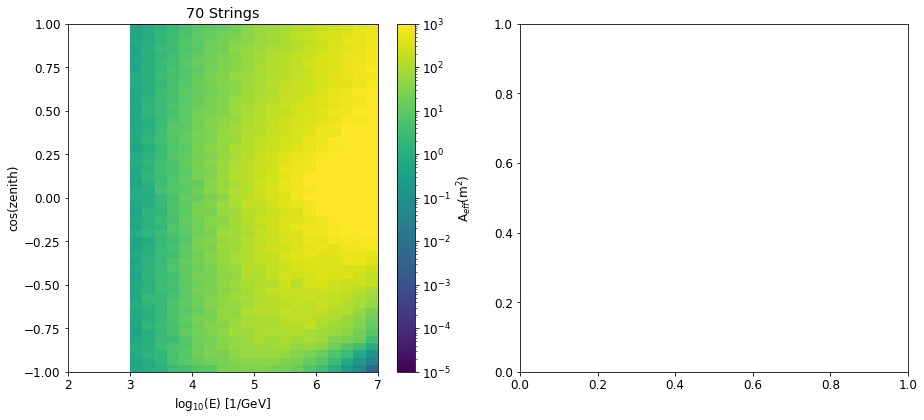

In [97]:
save =True
local = True
plt.rc('font', size=12)
fig, axs = plt.subplots(1,2, figsize=(13,6))
#vmins = [1e2, 5e2, 1e3]
#vmaxs=[1e3,5e3,1e4]
for i, string in enumerate([70]):
    ax = axs[i]
    h2d = effa2d(string, local)
    print(h2d)
    #h2d.values[:,:24] = 0
    h2d
    if save:
        if local:
            np.save('../data/PONE_nu_effa_{}_string_binning'.format(string), h2d)
        else:
            np.save('../data/PONE_nu_effa_{}_string_eq'.format(string), h2d)

    #fig, ax = plt.subplots()
    hl.plot2d(ax, h2d, cbar=True, clabel='A$_{eff}$(m$^2$)', log=True, vmin=1e-5, vmax=1e3)
    ax.set_yticks(np.arange(-1,1.01,.25))
    ax.set_ylabel('cos(zenith)')
    ax.set_xlabel('log$_{10}$(E) [1/GeV]')
    ax.set_title('{} Strings'.format(string))
    #ax.set_aspect('equal')
plt.tight_layout()

In [ ]:
h2d

In [ ]:
fig, ax = plt.subplots()
h2d = np.load('../data/PONE_nu_effa_70_string_binning.npy', allow_pickle=True)[()]
hl.plot2d(ax, h2d, cbar=True, clabel='A$_{eff}$(m$^2$)', log=True, vmin=1e-5, vmax=1e3)


AttributeError: 'DataFrame' object has no attribute 'true_dec'

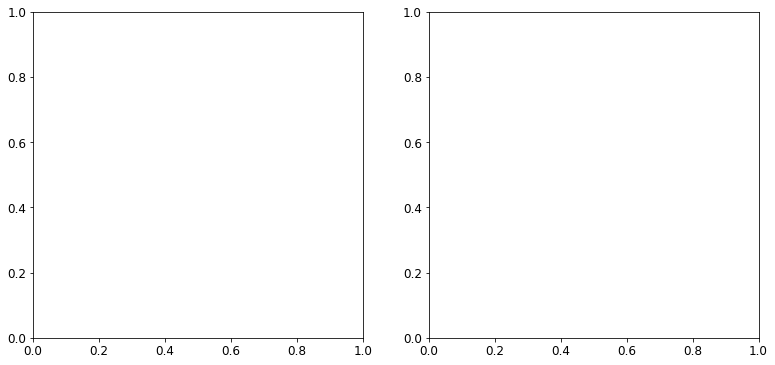

In [92]:
save =False
local = False
plt.rc('font', size=12)
fig, axs = plt.subplots(1,2, figsize=(13,6))
#vmins = [1e2, 5e2, 1e3]
#vmaxs=[1e3,5e3,1e4]
for i, string in enumerate([70]):
    ax = axs[i]
    h2d = effa2d(string, local)
    if save:
        if local:
            np.save('../data/PONE_nu_effa_{}_string'.format(string), h2d)
        else:
            np.save('../data/PONE_nu_effa_{}_string_eq'.format(string), h2d)

    #fig, ax = plt.subplots()
    hl.plot2d(ax, h2d, cbar=True, clabel='A$_{eff}$(m$^2$)', log=True, vmin=1e-5, vmax=1e3)
    ax.set_yticks(np.arange(-1,1.01,.25))
    ax.set_ylabel('sin(dec)')
    ax.set_xlabel('log$_{10}$(E) [1/GeV]')
    ax.set_title('{} Strings'.format(string))
    #ax.set_aspect('equal')
plt.tight_layout()